# Assignment 3.3 Northwinds Database EDA

## Description
### In this notebook, we will explore the Northwinds database. To narrow the scope of this assignment, we will focus on the top 5 expanded price by city.

## Source
### Northwinds database

## Data Dictionary
### `Orders`
- #### OrderID: Primary key
- #### CustomerID: Foreign key to join with Customers table
- #### EmployeeID: Foreign key to join with Employees table
- #### OrderDate: Date when order was placed
- #### RequriedDate: Date when order is required to arrive
- #### ShipDate: Date when order is shipped
- #### ShipVia: Foreign key for Shipers table
- #### Freight: Freight
- #### ShipName: Customer name
- #### ShipAddress: Customer address
- #### ShipCity: Customer's city of address
- #### ShipRegion: Customer's region of address
- #### ShipPostalCode: Customer's postal code of address
- #### ShipCountry: Customer's country of address

### `Order Details`
- #### OrderID: Foreign key to join with Orders table
- #### ProductID: Foreign key to join with Product table
- #### UnitPrice: Unit price of product
- #### Quantity: Quantity of product on order
- #### Discount: Discount rate of product

### `Products`
- #### ProductID: Primary key
- #### ProductName: Name of product
- #### SupplierID: Foreign key to join with Supplier table
- #### CategoryID: Foreign key to join with Category table
- #### QuantityPerUnit: Quantity per unit
- #### UnitPrice: Unit price
- #### UnitsInStock: Units in stock
- #### UnitsOnOrder: Units on order
- #### ReorderLevel: Reorderlevel
- #### Discontinued: Whether product is discontinued or not

In [ ]:
# Install MSSQL Driver
%%sh
apt-get install -y unixodbc-dev
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/$(lsb_release -rs)/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

# Restart the session after this install or you'll still get a dirver issue
- Runtime -> Restart Session
- You do not need to re-run the above cell after the restart

In [2]:
# Install pyodbc
!pip install pyodbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.7/334.7 kB 6.5 MB/s eta 0:00:00


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import pyodbc
import pandas as pd

server = 'P3NWPLSK12SQL-v12.shr.prod.phx3.secureserver.net'
user = 'datastudent'
pw = 'dataprog2023!'
database = 'Northwinds'

conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={user};'
    f'PWD={pw};'
    f'trusted_connect=yes;'
)

In [35]:
query = " \
SELECT SUM(OD.UnitPrice) AS UnitPrice \
    , SUM(OD.Quantity) AS Quantity \
    , SUM(OD.Discount) AS Discount \
    , SUM(OD.UnitPrice * (1 - OD.Discount) * OD.Quantity) AS ExpandedPrice \
    , O.ShipCity \
FROM [Northwinds].[dbo].[Order Details] AS OD \
LEFT JOIN [Northwinds].[dbo].[Orders] as O \
    ON OD.OrderID = O.OrderID \
LEFT JOIN [Northwinds].[dbo].[Products] AS P \
    ON P.ProductID = OD.ProductID \
GROUP BY O.ShipCity \
ORDER BY SUM(OD.UnitPrice * (1 - OD.Discount) * OD.Quantity) DESC \
"

In [38]:
df = pd.read_sql(query, conn)
top5_df = df.head()
top5_df

<ipython-input-38-246986540206>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,UnitPrice,Quantity,Discount,ExpandedPrice,ShipCity
0,2739.95,3961,5.95,110277.305077,Cunewalde
1,2666.67,4543,6.95,104874.978218,Graz
2,2679.66,4958,9.60,104361.949699,Boise
3,2343.83,1893,4.90,51956.979963,Rio de Janeiro
4,2182.90,1383,2.49,51097.800404,Albuquerque


In [39]:
top5_df.isnull().sum()

UnitPrice        0
Quantity         0
Discount         0
ExpandedPrice    0
ShipCity         0
dtype: int64

In [42]:
df_stats_mean = df.describe().loc[['mean', 'std']]
df_stats_mean

,UnitPrice,Quantity,Discount,ExpandedPrice
mean,807.155857,733.100000,1.729143,18082.757677
std,646.309367,933.673501,1.927686,22514.071652


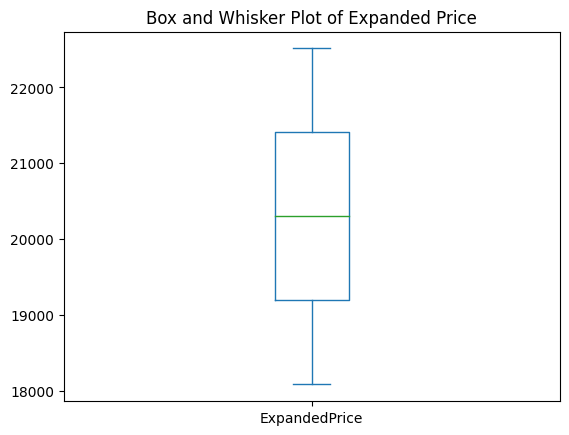

In [46]:
df_stats_mean[['ExpandedPrice']].plot(kind='box')
plt.title('Box and Whisker Plot of Expanded Price')
plt.show()

In [48]:
expanded_price_df = top5_df.groupby(["ShipCity"]).ExpandedPrice.sum().reset_index()
expanded_price_df

,ShipCity,ExpandedPrice
0,Albuquerque,51097.800404
1,Boise,104361.949699
2,Cunewalde,110277.305077
3,Graz,104874.978218
4,Rio de Janeiro,51956.979963


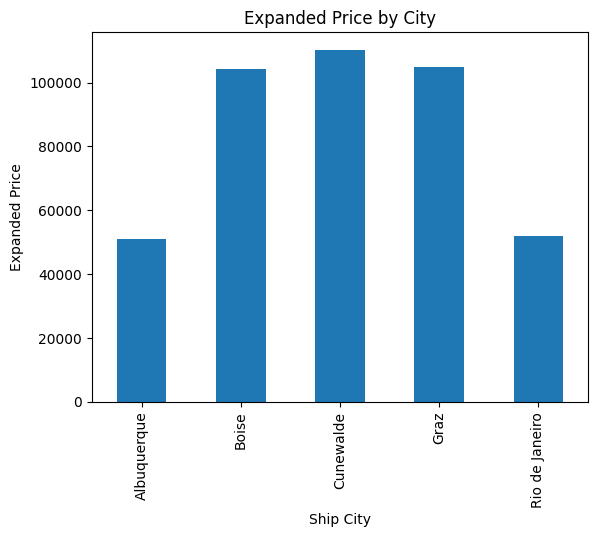

In [50]:
expanded_price_df.plot(kind='bar', x='ShipCity', y='ExpandedPrice', legend=None)
plt.title('Expanded Price by City')
plt.xlabel('Ship City')
plt.ylabel('Expanded Price')
plt.show()